In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# <p style="background-color:#E598D8;font-family:newtimeroman;color:#E1F16B;font-size:150%;text-align:center;border-radius:20px 60px;">SPAM OR HAM</p>

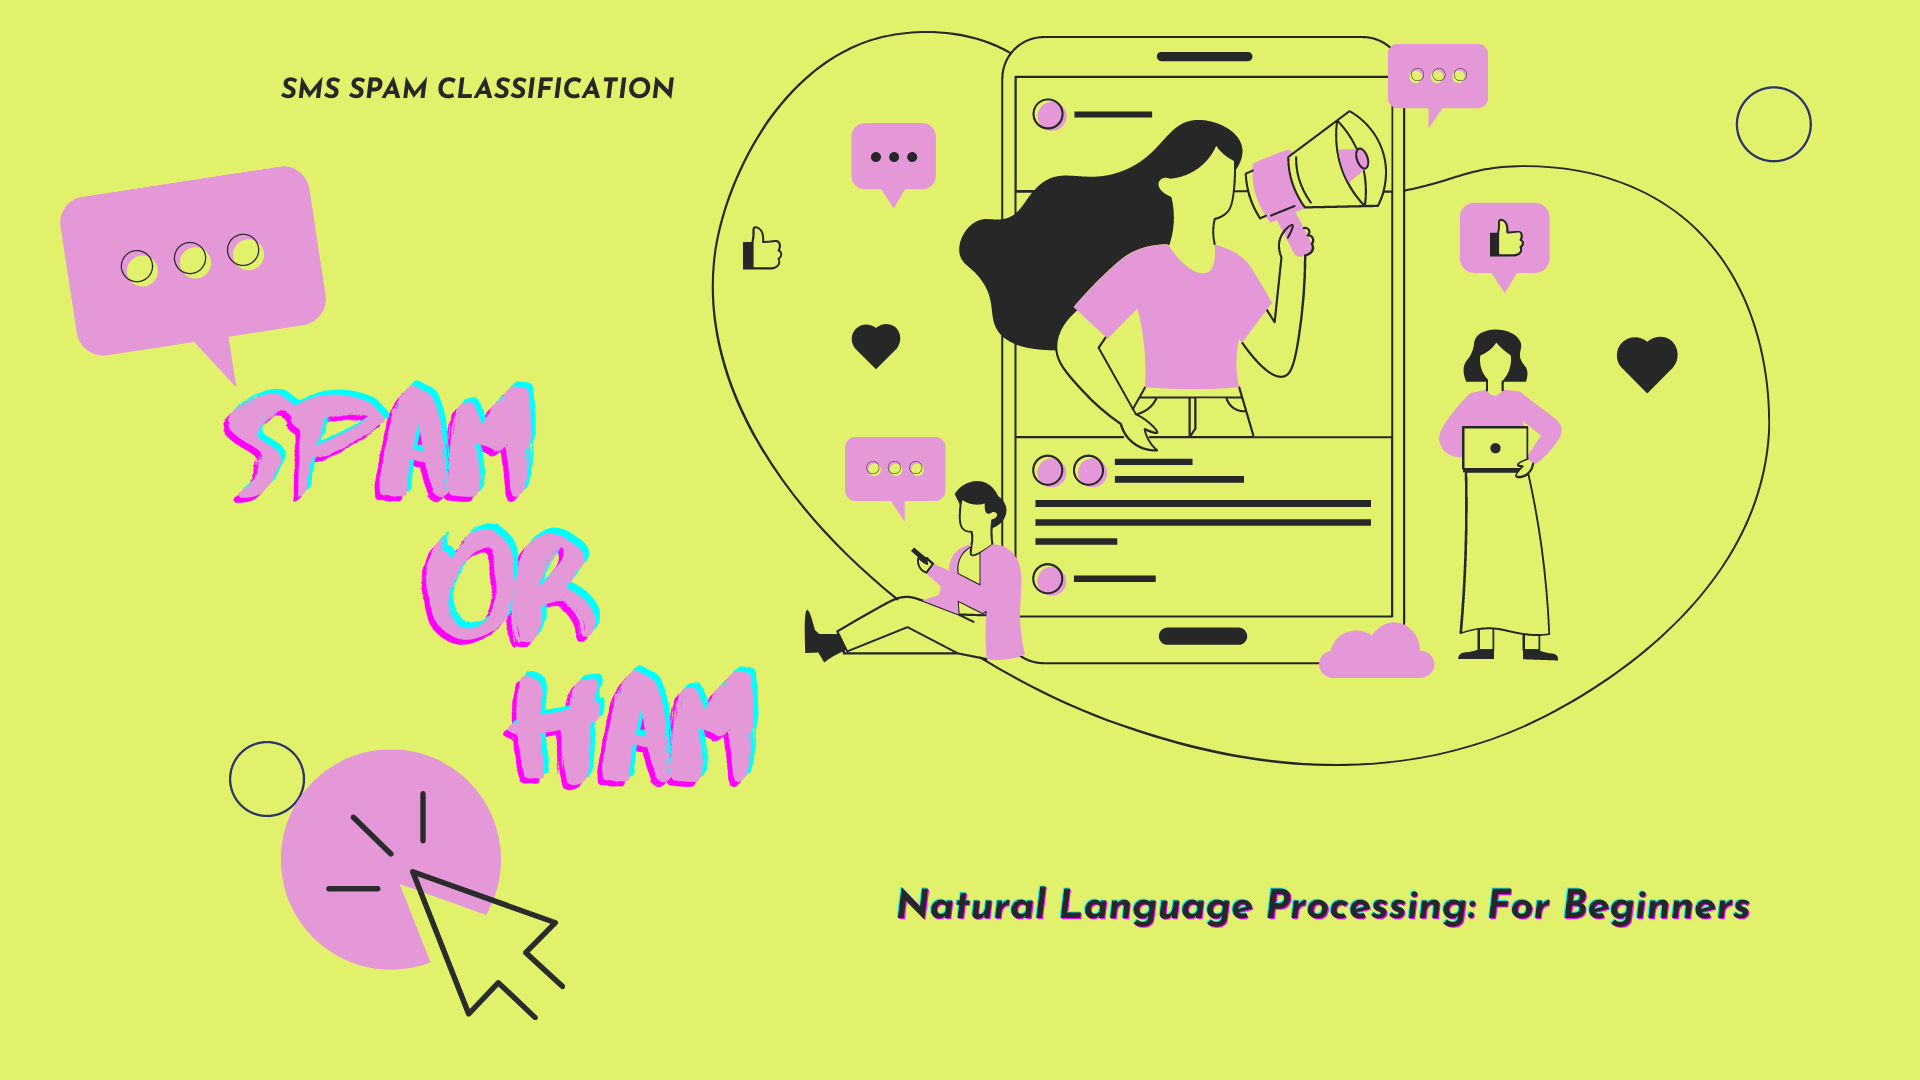

   <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#E598D8;font-family:newtimeroman;color:#E1F16B;font-size:150%;text-align:center;border-radius:20px 60px;">TABLE OF CONTENTS</p>   
    
* [1. IMPORTING LIBRARIES](#1)
    
* [2. LOADING DATA](#2)
    
* [3. DATA EXPLORATION](#3)
    * [3.1 FEATURE ENGINEERING](#3.1)
    * [3.2 OUTLIER DETECTION](#3.2)
    
    
* [4. DATA PREPREPROCESSING](#4)
    
    * [4.1 CLEANING TEXT](#4.1)
    * [4.2 TOKENIZATION](#4.2)
    * [4.3 REMOVING STOPWORDS](#4.3)
    * [4.4 LEMMATIZATION](#4.4) 
    
    
* [5. VECTORIZATION](#5) 
      
* [6. MODEL BUILDING](#6)
    
* [7. EVALUATING MODELS](#7)
    
* [8. END](#8)

<p style="background-color:#E1F16B;font-family:newtimeroman;color:#E598D8;font-size:150%;text-align:center;border-radius:20px 60px;">START</p>

 <a id="1"></a>
# <p style="background-color:#E598D8;font-family:newtimeroman;color:#E1F16B;font-size:150%;text-align:center;border-radius:20px 60px;">IMPORTING LIBRARIES</p>

In [ ]:
#Importing all the libraries to be used
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics

<a id="2"></a>
# <p style="background-color:#E598D8;font-family:newtimeroman;color:#E1F16B;font-size:150%;text-align:center;border-radius:20px 60px;">LOADING DATA</p>

In [ ]:
#Loading data
data = pd.read_csv("../input/sms-spam-collection-dataset/spam.csv")
data.info()

In [ ]:
# Dropping the redundent looking collumns (for this project)
to_drop = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"]
data = data.drop(data[to_drop], axis=1)
# Renaming the columns because I feel fancy today 
data.rename(columns = {"v1":"Target", "v2":"Text"}, inplace = True)
data.head()

**The dataset consists of 5,574 messages in English. The data is designated as being ham or spam.  Dataframe has two columns. The first column is "Target" indicating the class of message as ham or spam and the second "Text" column is the string of text.** 

<a id="3"></a>
# <p style="background-color:#E598D8;font-family:newtimeroman;color:#E1F16B;font-size:150%;text-align:center;border-radius:20px 60px;">DATA EXPLORATION</p>

In [ ]:
#Palette
cols= ["#E1F16B", "#E598D8"] 
#first of all let us evaluate the target and find out if our data is imbalanced or not
plt.figure(figsize=(12,8))
fg = sns.countplot(x= data["Target"], palette= cols)
fg.set_title("Count Plot of Classes", color="#58508d")
fg.set_xlabel("Classes", color="#58508d")
fg.set_ylabel("Number of Data points", color="#58508d")

**Note:** From the above countplot the data imbalance is quite evident. 

<a id="3.1"></a>
# <p style="background-color:#E1F16B;font-family:newtimeroman;color:#E598D8;text-align:center;font-size:80%;border-radius:20px 60px;">FEATURE ENGINEERING</p>

For the purpose of data exploration, I am creating new features 

* No_of_Characters: Number of characters in the text message
* No_of_Words: Number of words in the text message
* No_of_sentence: Number of sentences in the text message  

In [ ]:
#Adding a column of numbers of charachters,words and sentences in each msg
data["No_of_Characters"] = data["Text"].apply(len)
data["No_of_Words"]=data.apply(lambda row: nltk.word_tokenize(row["Text"]), axis=1).apply(len)
data["No_of_sentence"]=data.apply(lambda row: nltk.sent_tokenize(row["Text"]), axis=1).apply(len)

data.describe().T

#PS. At this step, I tokenised the words and sentences and used the length of the same. 
#More on Tokenizing later in the notebook.

In [ ]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="Target",palette=cols)
plt.show(fg)

**Note:** From the pair plot, we can see a few outliers all in the class ham. This is interesting as we could put a cap over one of these. As they essentially indicate the same thing ie the length of SMS. 

Next, I shall be dropping the outliers

<a id="3.2"></a>
# <p style="background-color:#E1F16B;font-family:newtimeroman;color:#E598D8;text-align:center;font-size:80%;border-radius:20px 60px;">OUTLIER DETECTION</p>

In [ ]:
#Dropping the outliers. 
data = data[(data["No_of_Characters"]<350)]
data.shape

In [ ]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="Target",palette=cols)
plt.show(fg)

*Of course, I already knew it would just zoom into, but I still replotted it because look at all those pretty colours! (:*

<a id="4"></a>
# <p style="background-color:#E598D8;font-family:newtimeroman;color:#E1F16B;font-size:150%;text-align:center;border-radius:20px 60px;">DATA PREPREPROCESSING</p>

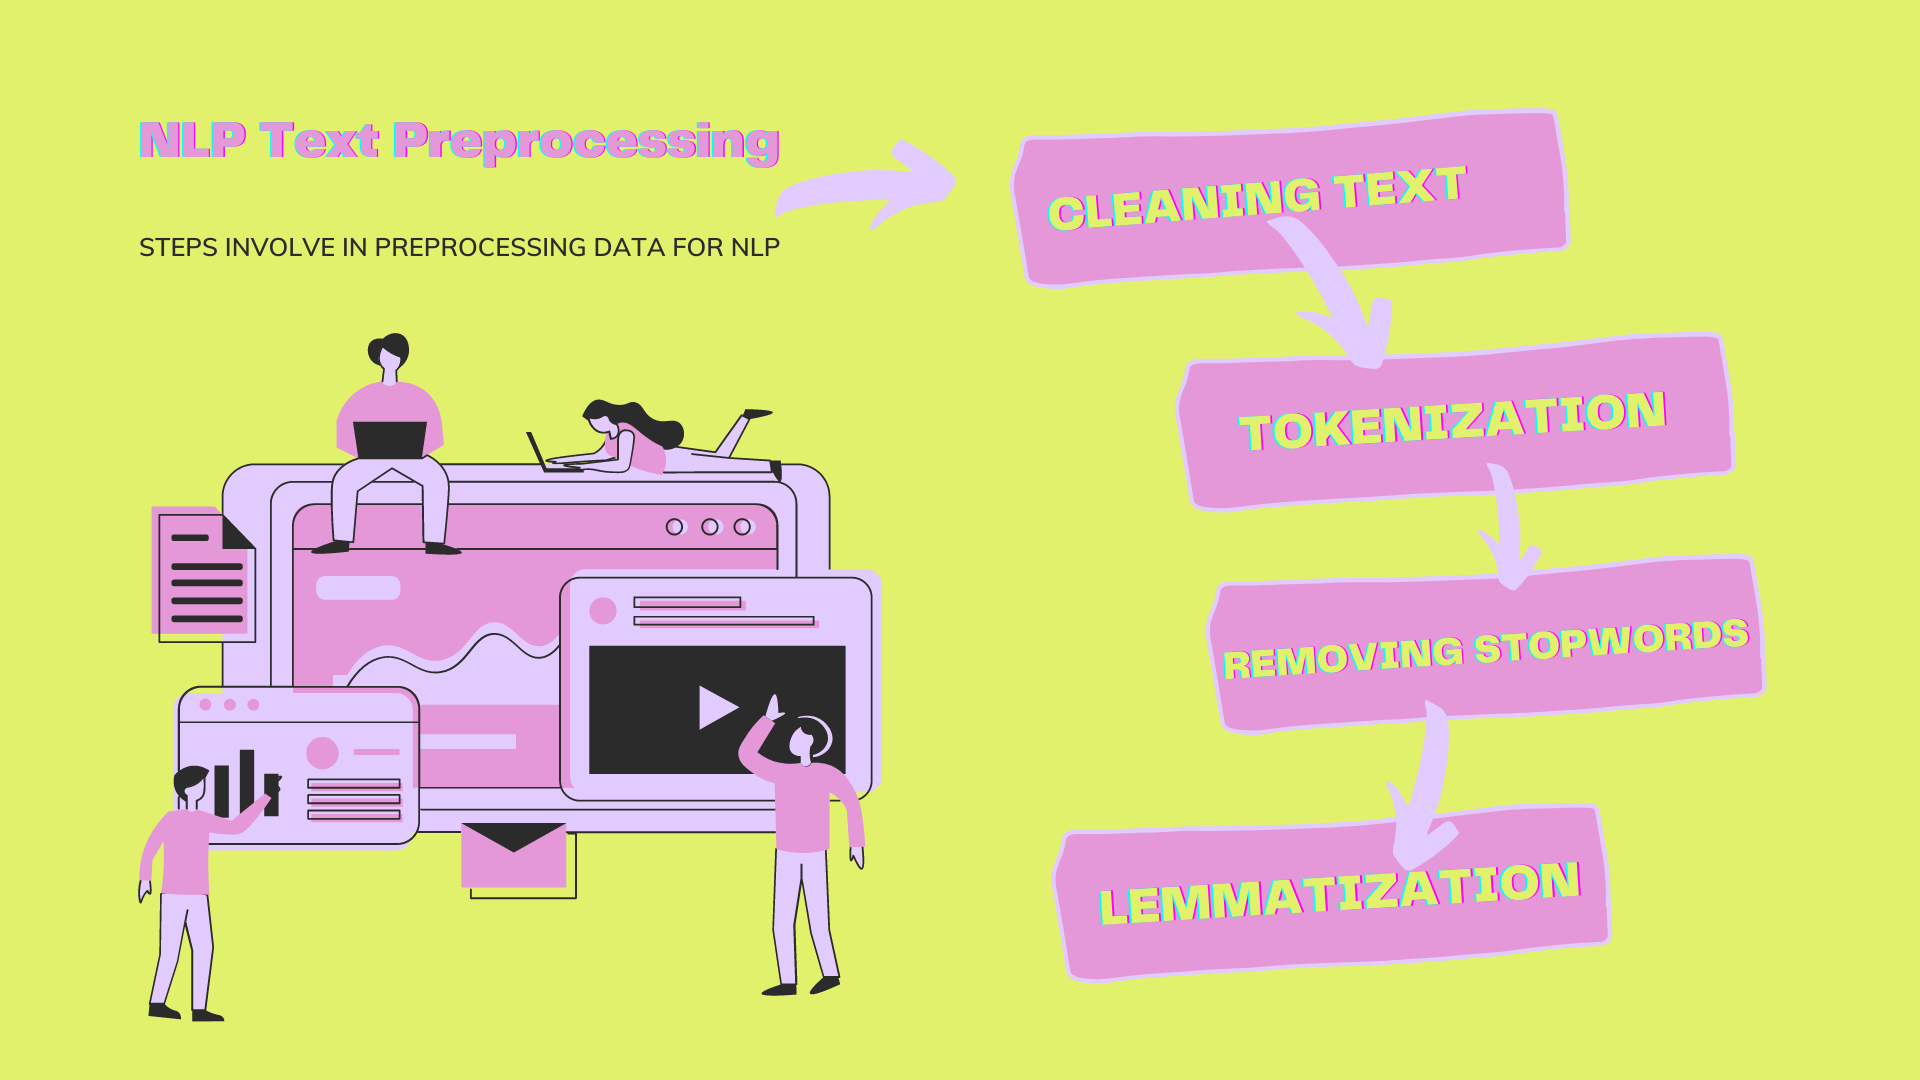

<a id="4.1"></a>
# <p style="background-color:#E1F16B;font-family:newtimeroman;color:#E598D8;text-align:center;font-size:80%;border-radius:20px 60px;">CLEANING TEXT</p>

The data cleaning process NLP is crucial. The computer doesn’t understand the text. for the computer, it is just a cluster of symbols. To further process the data we need to make the data cleaner. 

* In the first step we extract only the alphabetic characters by this we are removing punctuation and numbers. 
* In the next step, we are converting all the characters into lowercase. 

This text will be then used in further procrssing

In [ ]:
#Lets have a look at a sample of texts before cleaning
print("\033[1m\u001b[45;1m The First 5 Texts:\033[0m",*data["Text"][:5], sep = "\n")

In [ ]:
# Defining a function to clean up the text
def Clean(Text):
    sms = re.sub('[^a-zA-Z]', ' ', Text) #Replacing all non-alphabetic characters with a space
    sms = sms.lower() #converting to lowecase
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

data["Clean_Text"] = data["Text"].apply(Clean)
#Lets have a look at a sample of texts after cleaning
print("\033[1m\u001b[45;1m The First 5 Texts after cleaning:\033[0m",*data["Clean_Text"][:5], sep = "\n")

<a id="4.2"></a>
# <p style="background-color:#E1F16B;font-family:newtimeroman;color:#E598D8;text-align:center;font-size:80%;border-radius:20px 60px;">TOKENIZATION</p>

**Tokenization** is breaking complex data into smaller units called tokens. It can be done by splitting paragraphs into sentences and sentences into words. 
I am splitting the Clean_Text into words at this step.

In [ ]:
data["Tokenize_Text"]=data.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)

print("\033[1m\u001b[45;1m The First 5 Texts after Tokenizing:\033[0m",*data["Tokenize_Text"][:5], sep = "\n")

<a id="4.3"></a>
# <p style="background-color:#E1F16B;font-family:newtimeroman;color:#E598D8;text-align:center;font-size:80%;border-radius:20px 60px;">REMOVING STOPWORDS</p>

**Stopwords** are frequently occurring words(*such as few, is, an, etc*). These words hold meaning in sentence structure, but do not contribute much to language processing in NLP. For the purpose of removing redundancy in our processing, I am removing those. NLTK library has a set of default stopwords that we will be removing. 

In [ ]:
# Removing the stopwords function
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

data["Nostopword_Text"] = data["Tokenize_Text"].apply(remove_stopwords)

print("\033[1m\u001b[45;1m The First 5 Texts after removing the stopwords:\033[0m",*data["Nostopword_Text"][:5], sep = "\n")

<a id="4.4"></a>
# <p style="background-color:#E1F16B;font-family:newtimeroman;color:#E598D8;text-align:center;font-size:80%;border-radius:20px 60px;">LEMMATIZATION</p>

**Stemming** is the process of getting the root form of a word. Stem or root is the part to which inflectional affixes are added. The stem of a word is created by removing the prefix or suffix of a word. It goes back to the etymology of the word. Languages evolve over time. Many different languages branch into each other; for example, English is a derivative of Latin. Thus, stemming a word takes it back to the root word. 

**lemmatization** also converts a word to its root form. However, the difference is that lemmatization ensures that the root word belongs to the language one is dealing with, in our case it is English. If we use lemmatization the output would be in English. 

In [ ]:
lemmatizer = WordNetLemmatizer()
# lemmatize string
def lemmatize_word(text):
    #word_tokens = word_tokenize(text)
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

data["Lemmatized_Text"] = data["Nostopword_Text"].apply(lemmatize_word)
print("\033[1m\u001b[45;1m The First 5 Texts after lemitization:\033[0m",*data["Lemmatized_Text"][:5], sep = "\n")

<a id="5"></a>
# <p style="background-color:#E598D8;font-family:newtimeroman;font-size:150%;color:#E1F16B;text-align:center;border-radius:20px 60px;">VECTORIZE</p>

**TF-IDF** in NLP stands for Term Frequency – Inverse document frequency. In NLP cleaned data needs to be converted into a numerical format where each word is represented by a matrix. This is also known as word embedding or Word vectorization.

Term Frequency (TF) = (Frequency of a term in the document)/(Total number of terms in documents)
Inverse Document Frequency(IDF) = log( (total number of documents)/(number of documents with term t))
I will be using TfidfVectorizer() to vectorize the preprocessed data. 

**Steps in the Vectorizing:**
* Creating a corpus of lemmatized text
* Converting the corpus in vector form
* Label Encoding the classes in Target
 
*Note: So far we have been stalking up columns in our data for the purpose of explanation*

In [ ]:
#Creating a corpus of text feature to encode further into vectorized form
corpus= []
for i in data["Lemmatized_Text"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)
    
corpus[:5]
print("\033[1m\u001b[45;1m The First 5 lines in corpus :\033[0m",*corpus[:5], sep = "\n")

In [ ]:
#Changing text data in to numbers. 
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()
#Let's have a look at our feature 
X.dtype

In [ ]:
#Label encode the Target and use it as y
label_encoder = LabelEncoder()
data["Target"] = label_encoder.fit_transform(data["Target"])

<a id="6"></a>
# <p style="background-color:#E598D8;font-family:newtimeroman;font-size:150%;color:#E1F16B;text-align:center;border-radius:20px 60px;">MODEL BUILDING</p>

**Steps involved in the Model Building**
* Setting up features and target as X and y
* Splitting the testing and training sets
* Build a pipeline of model for four different classifiers.
  1. Naïve Bayes
  2. RandomForestClassifier
  3. KNeighborsClassifier
  4. Support Vector Machines
* Fit all the models on training data
* Get the cross-validation on the training set for all the models for accuracy

In [ ]:
#Setting values for labels and feature as y and X(we already did X in vectorizing...)
y = data["Target"] 
# Splitting the testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Testing on the following classifiers
classifiers = [MultinomialNB(), 
               RandomForestClassifier(),
               KNeighborsClassifier(), 
               SVC()]
for cls in classifiers:
    cls.fit(X_train, y_train)

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "NaiveBayes", 1: "RandomForest", 2: "KNeighbours",3: "SVC"}

In [ ]:
# Cossvalidation 
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X_train,y_train,scoring="accuracy", cv=10)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

<a id="7"></a>
# <p style="background-color:#E598D8;font-family:newtimeroman;font-size:150%;color:#E1F16B;text-align:center;border-radius:20px 60px;">EVALUATING MODELS</p>
**Testing the models on Testset**
* Accuracy Report
* Confusion Matrix

In [ ]:
# Model Evaluation
# creating lists of varios scores
precision =[]
recall =[]
f1_score = []
trainset_accuracy = []
testset_accuracy = []

for i in classifiers:
    pred_train = i.predict(X_train)
    pred_test = i.predict(X_test)
    prec = metrics.precision_score(y_test, pred_test)
    recal = metrics.recall_score(y_test, pred_test)
    f1_s = metrics.f1_score(y_test, pred_test)
    train_accuracy = model.score(X_train,y_train)
    test_accuracy = model.score(X_test,y_test)
  
    #Appending scores
    precision.append(prec)
    recall.append(recal)
    f1_score.append(f1_s)
    trainset_accuracy.append(train_accuracy)
    testset_accuracy.append(test_accuracy)


In [ ]:
# initialise data of lists.
data = {'Precision':precision,
'Recall':recall,
'F1score':f1_score,
'Accuracy on Testset':testset_accuracy,
'Accuracy on Trainset':trainset_accuracy}
# Creates pandas DataFrame.
Results = pd.DataFrame(data, index =["NaiveBayes", "RandomForest", "KNeighbours","SVC"])

In [ ]:
cmap2 = ListedColormap(["#E2CCFF","#E598D8"])
Results.style.background_gradient(cmap=cmap2)

In [ ]:
cmap = ListedColormap(["#E1F16B", "#E598D8"])
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for cls, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap= cmap,   
                          )
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()


**<span style="color:#E598D8;"> If you liked this Notebook, please do upvote.</span>**

**<span style="color:#E598D8;"> If you have any suggestions or questions, feel free to comment!</span>**

**<span style="color:#E598D8;"> Best Wishes!</span>**

<a id="8"></a>
# <p style="background-color:#E598D8;font-family:newtimeroman;font-size:150%;color:#E1F16B;text-align:center;border-radius:20px 60px;">END</p>